# Analysis of Section 5

In [1]:
library(ggplot2)
library(ggpubr)
library(dplyr)

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'ggpubr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



### Set parameters for chosen example

In [2]:
path = "../data/runs/mlp/"
dataset = "shuttle"
iter = 1
feat = "weight_decay"

### Get all relevant data for a specific dataset

In [3]:
data.list = readRDS(paste0(path, dataset, "/2_3_effects_and_trees/eval_SS_L2_20_1000.rds"))
features  = names(data.list$result[[1]]$reslist[[1]])
data      = data.list$result[[1]]$reslist[[iter]][[feat]]
optima    = readRDS(paste0(path, dataset,"/1_1_mlrmbo_runs/mlrmbo_run_lambda_1_30repls.rds" ))
traindata = optima$result[[iter]]$opt.path
optimum   = traindata[which.min(traindata$y), features]
gt        = readRDS(paste0(path, dataset, "/2_2_groundtruth_pdps/gtpdp_20_1000.rds"))
gt        = gt[[1]][[feat]][[1]]


### Extract PDP and ICE curve data 

In [4]:
data.pdp       = data$res.pdp
data.ice       = data$res.ice

### Extract tree and subregions of first split 

In [5]:
tree = data$trees

# first split indices
ind.left = tree[[1]][[2]]$left.child$subset.idx
ind.right = tree[[1]][[2]]$right.child$subset.idx

# add subregional information to ice curves
data.ice$node = ifelse(data.ice$.id %in% ind.left, "left", "right")

### Calculate PDP and confidence estimates for subregions after first split 

In [17]:
# PDP of left subregion and associated confidence bands
pdp.left = data.ice[data.ice$.id %in% ind.left,] %>% group_by(get(feat)) %>% summarise(mean.left = mean(mean), sd.left = mean(sd))
pdp.left$lower = pdp.left$mean.left - pdp.left$sd.left*1.96
pdp.left$upper = pdp.left$mean.left + pdp.left$sd.left*1.96
colnames(pdp.left) = c(feat, "mean", "sd",   "lower" , "upper")

# PDP of right subregion and associated confidence bands
pdp.right = data.ice[data.ice$.id %in% ind.right,] %>% group_by(get(feat)) %>% summarise(mean.right = mean(mean), sd.right = mean(sd))
pdp.right$lower = pdp.right$mean.right - pdp.right$sd.right*1.96
pdp.right$upper = pdp.right$mean.right + pdp.right$sd.right*1.96
colnames(pdp.right) = c(feat, "mean", "sd",   "lower" , "upper")

# true estimated PDP for subregions
gt.ice = gt[gt$.type == "ice",]
# left subregion
gt.left = gt.ice[gt.ice$.id %in% ind.left,] %>% group_by(get(feat)) %>% summarise(mean.left = mean(mean))
colnames(gt.left) = c(feat, "mean")
# right subregion
gt.right = gt.ice[gt.ice$.id %in% ind.right,] %>% group_by(get(feat)) %>% summarise(mean.right = mean(mean))
colnames(gt.right) = c(feat, "mean")

### Create plots of Figure 4 

In [7]:
# set theme for plots
theme_set(theme_pubr(legend = "none"))

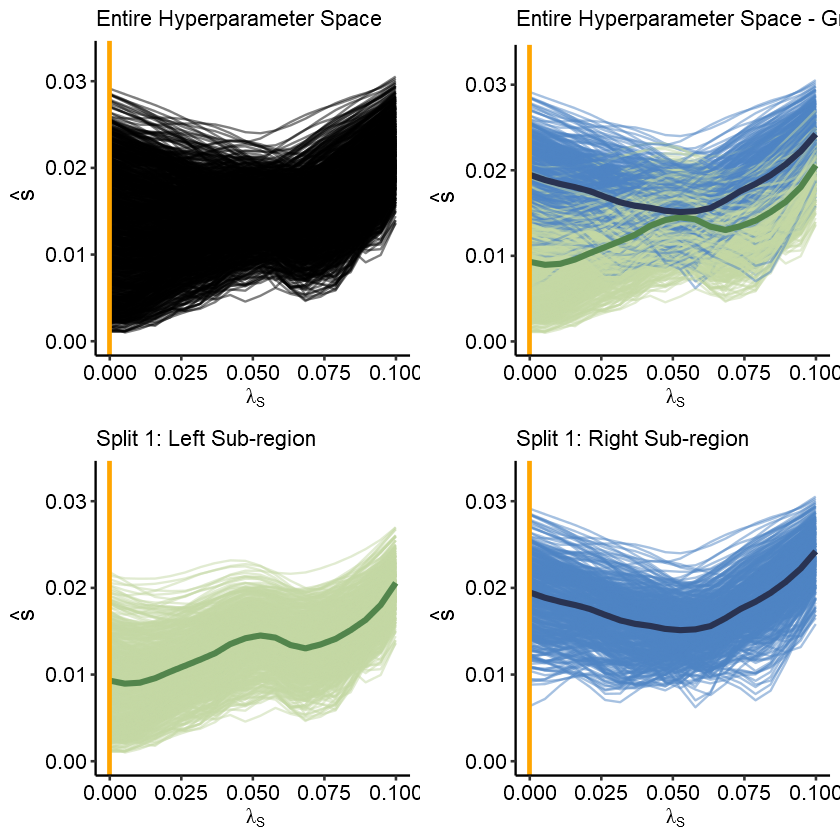

In [8]:
# top left: before grouping
p.sd = ggplot(data.ice, aes_string(x = feat, y = "sd", group = ".id")) + geom_line(alpha = 0.5) +
  geom_vline(aes(xintercept = as.numeric(optimum[feat])), colour = "orange", lwd = 1) +
  xlab(~ paste(lambda["S"])) + ylab(~ paste(hat("s"))) + ggtitle("Entire Hyperparameter Space") + ylim(0,0.033) +
  theme(plot.caption = element_text(hjust = 0, face= "italic", size = 12),
        plot.title = element_text(size = 13),
        axis.title.y = element_text(size = 14))


# top right: after grouping
p.sd.clust = ggplot(data.ice, aes_string(x = feat, y = "sd", color = "node")) + geom_line(alpha = 0.5,  aes(group = .id), show.legend = FALSE)  +
  scale_color_manual(values = c( "#C3D7A4",  "#4E84C4")) + 
  geom_line(data = pdp.left, aes_string(x = feat, y = "sd"), lwd = 1.3, col = "#52854C") +
  geom_line(data = pdp.right, aes_string(x = feat, y = "sd"), lwd = 1.3, col = "#293352") +
  geom_vline(aes(xintercept = as.numeric(optimum[feat])), colour = "orange", lwd = 1) +
  xlab(~ paste(lambda["S"])) + ylab(~ paste(hat("s"))) + ggtitle(expression(paste("Entire Hyperparameter Space - Grouped"))) + ylim(0,0.033) +
  theme(plot.caption = element_text(hjust = 0, face= "italic", size = 12),
        plot.title = element_text(size = 13),
        axis.title.y = element_text(size = 14))



# bottom left: left subregion after first split
p.sd.left = ggplot(data.ice[data.ice$.id %in% ind.left,], aes_string(x = feat, y = "sd")) + 
    geom_line(alpha = 0.5, aes(group = .id), col =  "#C3D7A4") +
    geom_line(data = pdp.left, aes_string(x = feat, y = "sd"), lwd = 1.3, col = "#52854C") +
    geom_vline(aes(xintercept = as.numeric(optimum[feat])), colour = "orange", lwd = 1) +
    xlab(~ paste(lambda["S"])) + ylab(~ paste(hat("s"))) + ggtitle("Split 1: Left Sub-region") + ylim(0,0.033) +
    theme(plot.caption = element_text(hjust = 0, face= "italic", size = 12),
        plot.title = element_text(size = 13),
        axis.title.y = element_text(size = 14))

# bottom right: right subregion after first split
p.sd.right = ggplot(data.ice[data.ice$.id %in% ind.right,], aes_string(x = feat, y = "sd")) + geom_line(alpha = 0.5, aes(group = .id), col =  "#4E84C4") +
  geom_line(data = pdp.right, aes_string(x = feat, y = "sd"), lwd = 1.3, col = "#293352") 
  geom_vline(aes(xintercept = as.numeric(optimum[feat])), colour = "orange", lwd = 1) +
  xlab(~ paste(lambda["S"])) + ylab(~ paste(hat("s"))) + ggtitle("Split 1: Right Sub-region") + ylim(0,0.033) +
  theme(plot.caption = element_text(hjust = 0, face= "italic", size = 12),
        plot.title = element_text(size = 13),
        axis.title.y = element_text(size = 14))

gridExtra::grid.arrange(p.sd, p.sd.clust, p.sd.left, p.sd.right, nrow = 2)

### Create plots of Figure 5

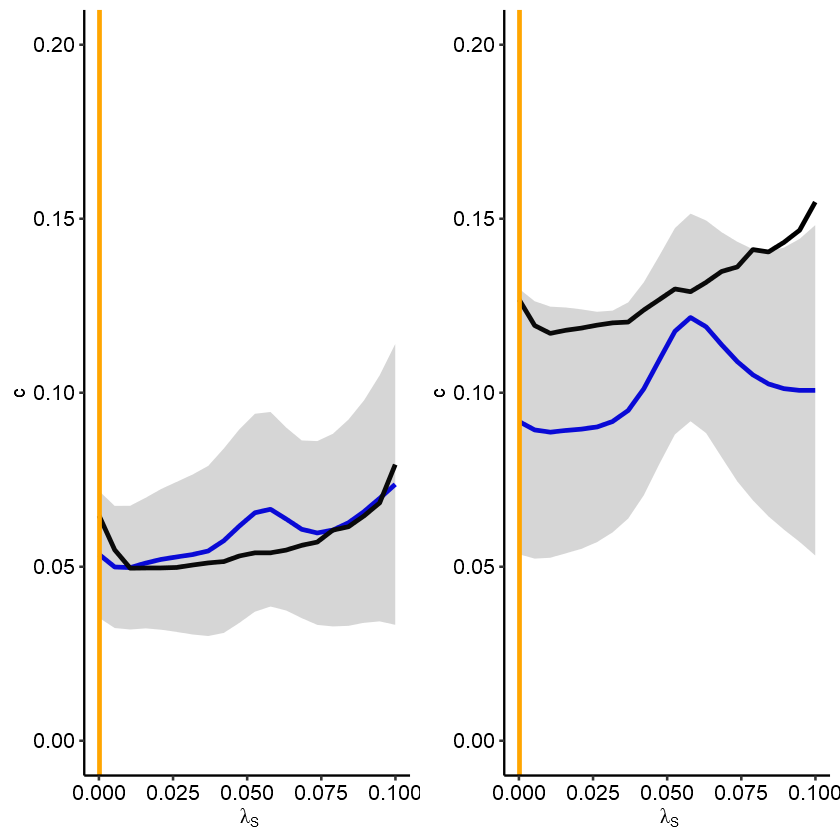

In [19]:
# left pdp with confidence bands
p.pdp.left = ggplot(data = pdp.left, aes_string(x = feat, y = "mean")) + 
    geom_line(colour = "blue", lwd = 1) + 
    geom_line(data = gt.left, colour = "black", lwd = 1) + 
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.2) + ylim(0,0.2) +
    geom_vline(aes(xintercept = as.numeric(optimum[feat])), colour = "orange", lwd = 1) +
    xlab(~ paste(lambda["S"])) + ylab("c") 

# right pdp with confidence bands
p.pdp.right = ggplot(data = pdp.right, aes_string(x = feat, y = "mean")) + 
    geom_line(colour = "blue", lwd = 1) + 
    geom_line(data = gt.right, colour = "black", lwd = 1) + 
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.2) + ylim(0,0.2) +
    geom_vline(aes(xintercept = as.numeric(optimum[feat])), colour = "orange", lwd = 1) +
    xlab(~ paste(lambda["S"])) + ylab("c") 

gridExtra::grid.arrange(p.pdp.left, p.pdp.right, nrow = 1)